In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/corpora/corpora/cattern/gradient_check.py
/kaggle/input/corpora/corpora/cattern/data_utils.py
/kaggle/input/corpora/corpora/cattern/__init__.py
/kaggle/input/corpora/corpora/wiki/thwiki_chk.txt
/kaggle/input/corpora/corpora/.ipynb_checkpoints/Word_Tokenizer_backup-checkpoint.ipynb
/kaggle/input/corpora/corpora/.ipynb_checkpoints/BackProp-checkpoint.ipynb
/kaggle/input/corpora/corpora/.ipynb_checkpoints/char2vec-checkpoint.ipynb
/kaggle/input/corpora/corpora/.ipynb_checkpoints/Word_Tokenizer.new-checkpoint.ipynb
/kaggle/input/corpora/corpora/.ipynb_checkpoints/Word_Tokenizer-checkpoint.ipynb
/kaggle/input/corpora/corpora/BEST/val/df_best_news_val.csv
/kaggle/input/corpora/corpora/BEST/val/df_best_novel_val.csv
/kaggle/input/corpora/corpora/BEST/val/df_best_encyclopedia_val.csv
/kaggle/input/corpora/corpora/BEST/val/df_best_article_val.csv
/kaggle/input/corpora/corpora/BEST/test/df_best_encyclopedia_test.csv
/kaggle/input/corpora/corpora/BEST/test/df_best_article_test.csv
/

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 1000)

# โหลด TensorBoard
%load_ext tensorboard

In [3]:
# Create a character map
CHARS = [
    '\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+',
    ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8',
    '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E',
    'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R',
    'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_',
    'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
    'n', 'o', 'other', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y',
    'z', '}', '~', 'ก', 'ข', 'ฃ', 'ค', 'ฅ', 'ฆ', 'ง', 'จ', 'ฉ', 'ช',
    'ซ', 'ฌ', 'ญ', 'ฎ', 'ฏ', 'ฐ', 'ฑ', 'ฒ', 'ณ', 'ด', 'ต', 'ถ', 'ท',
    'ธ', 'น', 'บ', 'ป', 'ผ', 'ฝ', 'พ', 'ฟ', 'ภ', 'ม', 'ย', 'ร', 'ฤ',
    'ล', 'ว', 'ศ', 'ษ', 'ส', 'ห', 'ฬ', 'อ', 'ฮ', 'ฯ', 'ะ', 'ั', 'า',
    'ำ', 'ิ', 'ี', 'ึ', 'ื', 'ุ', 'ู', 'ฺ', 'เ', 'แ', 'โ', 'ใ', 'ไ',
    'ๅ', 'ๆ', '็', '่', '้', '๊', '๋', '์', 'ํ', '๐', '๑', '๒', '๓',
    '๔', '๕', '๖', '๗', '๘', '๙', '‘', '’', '\ufeff'
]
CHARS_MAP = {v: k for k, v in enumerate(CHARS)}

def create_n_gram_df(df, n_pad):
    """
    Given an input dataframe, create a feature dataframe of shifted characters
    Input:
    df: timeseries of size (N)
    n_pad: the number of context. For a given character at position [idx],
        character at position [idx-n_pad/2 : idx+n_pad/2] will be used
        as features for that character.

    Output:
    dataframe of size (N * n_pad) which each row contains the character,
        n_pad_2 characters to the left, and n_pad_2 characters to the right
        of that character.
    """
    n_pad_2 = int((n_pad - 1)/2)
    for i in range(n_pad_2):
        df['char-{}'.format(i+1)] = df['char'].shift(i + 1)
        df['char{}'.format(i+1)] = df['char'].shift(-i - 1)
    return df[n_pad_2: -n_pad_2]


def prepare_feature(best_processed_path, option='train'):
    """
    Transform the path to a directory containing processed files
    into a feature matrix and output array
    Input:
    best_processed_path: str, path to a processed version of the BEST dataset
    option: str, 'train' or 'test'
    """
    # we use padding equals 21 here to consider 10 characters to the left
    # and 10 characters to the right as features for the character in the middle
    n_pad = 21
    n_pad_2 = int((n_pad - 1)/2)
    pad = [{'char': ' ', 'target': True}]
    df_pad = pd.DataFrame(pad * n_pad_2)

    df = []
    # article types in BEST corpus
    article_types = ['article'] #'article','encyclopedia', 'news', 'novel'
    for article_type in article_types:
        df.append(pd.read_csv(os.path.join(best_processed_path, option, 'df_best_{}_{}.csv'.format(article_type, option))))

    df = pd.concat(df)
    # pad with empty string feature at the start and the end
    df = pd.concat((df_pad, df, df_pad))

    # map characters to numbers, use 'other' if not in the predefined character set.
    df['char'] = df['char'].map(lambda x: CHARS_MAP.get(x, 80))

    # Use nearby characters as features
    df_with_context = create_n_gram_df(df, n_pad=n_pad)

    # Reorder column
    char_row = ['char' + str(i + 1) for i in range(n_pad_2)] + \
                ['char-' + str(i + 1) for i in range(n_pad_2)] + ['char']

    # convert pandas dataframe to numpy array to feed to the model
    x_char = df_with_context[char_row].to_numpy()
    y = df_with_context['target'].astype(int).to_numpy()
    
    return x_char, y

In [4]:
# Path to the preprocessed data
best_processed_path = '/kaggle/input/corpora/corpora/BEST'

# Load preprocessed BEST corpus
x_train_char, y_train = prepare_feature(best_processed_path, option='train')
x_val_char, y_val = prepare_feature(best_processed_path, option='val')
x_test_char, y_test = prepare_feature(best_processed_path, option='test')

# As a sanity check, we print out the size of the training, val, and test data.
print('Training data shape: ', x_train_char.shape)
print('Training data labels shape: ', y_train.shape)
print('Validation data shape: ', x_val_char.shape)
print('Validation data labels shape: ', y_val.shape)
print('Test data shape: ', x_test_char.shape)
print('Test data labels shape: ', y_test.shape)

Training data shape:  (3495942, 21)
Training data labels shape:  (3495942,)
Validation data shape:  (439473, 21)
Validation data labels shape:  (439473,)
Test data shape:  (476647, 21)
Test data labels shape:  (476647,)


In [5]:
# Print some entry from the data to make sure it is the same as what you think.
print('First 3 features: ', x_train_char[0:3])
print('First 30 class labels', y_train[:30])

#print char of feature 1
char = np.array(CHARS)

#A function for displaying our features in text
def translate_features(tfeature,index):
    feature = np.array(tfeature[index],dtype=int).reshape(21,1)
    #Convert to string
    char_list = char[feature]
    left = ''.join(reversed(char_list[10:20].reshape(10))).replace(" ", "")
    center = ''.join(char_list[20])
    right =  ''.join(char_list[0:10].reshape(10)).replace(" ", "")
    word = ''.join([left,' ',center,' ',right])
    return center + ': ' + word

for ind in range(0,3):
    word = translate_features(x_train_char,ind)
    print("{}  \t pred = {}".format(word,y_train[ind]))

First 3 features:  [[112. 140. 114. 148. 130. 142.  94. 142. 128. 128.   1.   1.   1.   1.
    1.   1.   1.   1.   1.   1.  97.]
 [140. 114. 148. 130. 142.  94. 142. 128. 128. 141.  97.   1.   1.   1.
    1.   1.   1.   1.   1.   1. 112.]
 [114. 148. 130. 142.  94. 142. 128. 128. 141. 109. 112.  97.   1.   1.
    1.   1.   1.   1.   1.   1. 140.]]
First 30 class labels [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0]
ค:  ค ณะตุลาการร  	 pred = 1
ณ: ค ณ ะตุลาการรั  	 pred = 0
ะ: คณ ะ ตุลาการรัฐ  	 pred = 0


# TASK 1: DENSE LAYER

In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import datetime

def get_feedforward_nn():
    # Input Layer รับข้อมูลขนาด 21 อักขระ
    input_layer = Input(shape=(21,))
    
    # Dense Layer แรกพร้อม ReLU activation
    dense1 = Dense(64, activation='relu')(input_layer)
    
    # Dense Layer ที่สองพร้อม ReLU activation
    dense2 = Dense(32, activation='relu')(dense1)
    
    # Output Layer ใช้ Sigmoid activation สำหรับการทำนายแบบไบนารี
    output_layer = Dense(1, activation='sigmoid')(dense2)
    
    # สร้างโมเดล
    model = Model(inputs=input_layer, outputs=output_layer)
    
    # Compile โมเดล ใช้ Adam optimizer และ binary cross-entropy loss function
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    
    model.summary()
    return model

# เรียกฟังก์ชันเพื่อสร้างโมเดล
model_feedforward_nn = get_feedforward_nn()

# กำหนดจำนวน epochs และ batch_size
epochs = 10
batch_size = 64

# ฝึกโมเดลด้วยข้อมูลการฝึก
model_feedforward_nn.fit(x_train_char, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(x_val_char, y_val))

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 21)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,521 (13.75 KB)

 Trainable params: 3,521 (13.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


I0000 00:00:1729266630.410887     100 service.cc:145] XLA service 0x7d1880006380 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729266630.410938     100 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729266630.410942     100 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  113/54625 ━━━━━━━━━━━━━━━━━━━━ 1:14 1ms/step - accuracy: 0.6876 - loss: 2.8472

I0000 00:00:1729266631.613182     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


54625/54625 ━━━━━━━━━━━━━━━━━━━━ 86s 2ms/step - accuracy: 0.8100 - loss: 0.4565 - val_accuracy: 0.8387 - val_loss: 0.3609
Epoch 2/10
54625/54625 ━━━━━━━━━━━━━━━━━━━━ 83s 2ms/step - accuracy: 0.8464 - loss: 0.3528 - val_accuracy: 0.8482 - val_loss: 0.3513
Epoch 3/10
54625/54625 ━━━━━━━━━━━━━━━━━━━━ 82s 2ms/step - accuracy: 0.8550 - loss: 0.3343 - val_accuracy: 0.8558 - val_loss: 0.3323
Epoch 4/10
54625/54625 ━━━━━━━━━━━━━━━━━━━━ 80s 1ms/step - accuracy: 0.8581 - loss: 0.3277 - val_accuracy: 0.8589 - val_loss: 0.3242
Epoch 5/10
54625/54625 ━━━━━━━━━━━━━━━━━━━━ 81s 1ms/step - accuracy: 0.8605 - loss: 0.3235 - val_accuracy: 0.8578 - val_loss: 0.3280
Epoch 6/10
54625/54625 ━━━━━━━━━━━━━━━━━━━━ 80s 1ms/step - accuracy: 0.8621 - loss: 0.3204 - val_accuracy: 0.8614 - val_loss: 0.3205
Epoch 7/10
54625/54625 ━━━━━━━━━━━━━━━━━━━━ 81s 1ms/step - accuracy: 0.8633 - loss: 0.3184 - val_accuracy: 0.8643 - val_loss: 0.3186
Epoch 8/10
54625/54625 ━━━━━━━━━━━━━━━━━━━━ 82s 1ms/step - accuracy: 0.8650 - lo

# TASK 2: EVALUATION

In [7]:
from sklearn.metrics import classification_report

def evaluate(x_test, y_test, model):
    # ทำการทำนายผลลัพธ์ด้วยโมเดลที่ฝึกแล้ว
    y_pred_prob = model.predict(x_test)
    
    # แปลงผลลัพธ์เป็นคลาส โดยกำหนด threshold ที่ 0.5
    y_pred = (y_pred_prob >= 0.5).astype(int)
    
    # สร้างรายงานการประเมินผล ซึ่งประกอบด้วย precision, recall, และ F1-score สำหรับแต่ละคลาส
    report = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'])
    
    # แสดงผลรายงานการประเมินผล
    print(report)
    
    return y_pred

# เรียกใช้ฟังก์ชัน evaluate ด้วยข้อมูลทดสอบ
y_pred = evaluate(x_test_char, y_test, model_feedforward_nn)

14896/14896 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step
              precision    recall  f1-score   support

     Class 0       0.88      0.94      0.91    346519
     Class 1       0.81      0.66      0.73    130128

    accuracy                           0.87    476647
   macro avg       0.85      0.80      0.82    476647
weighted avg       0.86      0.87      0.86    476647



In [8]:
evaluate(x_test_char, y_test, model_feedforward_nn)

14896/14896 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step
              precision    recall  f1-score   support

     Class 0       0.88      0.94      0.91    346519
     Class 1       0.81      0.66      0.73    130128

    accuracy                           0.87    476647
   macro avg       0.85      0.80      0.82    476647
weighted avg       0.86      0.87      0.86    476647



array([[1],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

# TASK 3: DROPOUT

In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def get_nn_with_dropout():
    # Input Layer รับข้อมูลขนาด 21 อักขระ
    input_layer = Input(shape=(21,))
    
    # Dense Layer แรกพร้อม ReLU activation และ Dropout
    dense1 = Dense(64, activation='relu')(input_layer)
    dropout1 = Dropout(0.5)(dense1)  # เพิ่ม Dropout 50%
    
    # Dense Layer ที่สองพร้อม ReLU activation และ Dropout
    dense2 = Dense(32, activation='relu')(dropout1)
    dropout2 = Dropout(0.5)(dense2)  # เพิ่ม Dropout 50%
    
    # Output Layer ใช้ Sigmoid activation สำหรับการทำนายแบบไบนารี
    output_layer = Dense(1, activation='sigmoid')(dropout2)
    
    # สร้างโมเดล
    model = Model(inputs=input_layer, outputs=output_layer)
    
    # Compile โมเดล ใช้ Adam optimizer และ binary cross-entropy loss function
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    
    model.summary()
    return model

# เรียกฟังก์ชันเพื่อสร้างโมเดลที่มี Dropout layers
print('start training')
model_nn_with_dropout = get_nn_with_dropout()

# กำหนดจำนวน epochs และ batch_size
epochs = 10
batch_size = 64

# ฝึกโมเดลด้วยข้อมูลการฝึก
model_nn_with_dropout.fit(x_train_char, y_train, epochs=epochs, batch_size=batch_size, verbose=2, validation_data=(x_val_char, y_val))

start training


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 21)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,521 (13.75 KB)

 Trainable params: 3,521 (13.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
54625/54625 - 84s - 2ms/step - accuracy: 0.7998 - loss: 0.5044 - val_accuracy: 0.7991 - val_loss: 0.4558
Epoch 2/10
54625/54625 - 76s - 1ms/step - accuracy: 0.8104 - loss: 0.4454 - val_accuracy: 0.8055 - val_loss: 0.4340
Epoch 3/10
54625/54625 - 77s - 1ms/step - accuracy: 0.8126 - loss: 0.4396 - val_accuracy: 0.8019 - val_loss: 0.4394
Epoch 4/10
54625/54625 - 78s - 1ms/step - accuracy: 0.8131 - loss: 0.4369 - val_accuracy: 0.8046 - val_loss: 0.4324
Epoch 5/10
54625/54625 - 77s - 1ms/step - accuracy: 0.8133 - loss: 0.4362 - val_accuracy: 0.8028 - val_loss: 0.4344
Epoch 6/10
54625/54625 - 77s - 1ms/step - accuracy: 0.8136 - loss: 0.4352 - val_accuracy: 0.8038 - val_loss: 0.4310
Epoch 7/10
54625/54625 - 77s - 1ms/step - accuracy: 0.8135 - loss: 0.4347 - val_accuracy: 0.8090 - val_loss: 0.4245
Epoch 8/10
54625/54625 - 77s - 1ms/step - accuracy: 0.8133 - loss: 0.4344 - val_accuracy: 0.8110 - val_loss: 0.4173
Epoch 9/10
54625/54625 - 76s - 1ms/step - accuracy: 0.8133 - loss: 0.434

In [10]:
evaluate(x_test_char, y_test, model_nn_with_dropout)

14896/14896 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step
              precision    recall  f1-score   support

     Class 0       0.80      0.99      0.88    346519
     Class 1       0.95      0.32      0.48    130128

    accuracy                           0.81    476647
   macro avg       0.87      0.66      0.68    476647
weighted avg       0.84      0.81      0.77    476647



array([[1],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

# TASK4: IMPLEMENT A BETTER MODEL.

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, Conv1D, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

# ล้าง session เก่าของ TensorFlow สำหรับการใช้งาน TensorBoard
K.clear_session()

def get_cnn_model():
    input_layer = Input(shape=(21,))

    # Embedding Layer
    embedding_layer = Embedding(input_dim=len(CHARS), output_dim=32, input_length=21)(input_layer)

    # 1D Convolution Layer
    conv_layer = Conv1D(filters=100, kernel_size=5, strides=1, activation='relu')(embedding_layer)
    
    # TimeDistributed Dense Layer
    time_dense = TimeDistributed(Dense(5, activation='relu'))(conv_layer)
    
    # Flatten Layer
    flatten_layer = Flatten()(time_dense)
    
    # Fully-connected Layer
    dense_layer = Dense(100, activation='relu')(flatten_layer)
    
    # Output Layer
    output_layer = Dense(1, activation='sigmoid')(dense_layer)

    # สร้างโมเดล
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    
    model.summary()
    return model

# สร้างโมเดล CNN
print('start training CNN model')
model_cnn = get_cnn_model()

epochs = 10
batch_size = 64
model_cnn.fit(x_train_char, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(x_val_char, y_val))

start training CNN model


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 21)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 21, 32)         │         5,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 17, 100)        │        16,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 17, 5)          │           505 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 85)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │         8,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,002 (121.10 KB)

 Trainable params: 31,002 (121.10 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
54625/54625 ━━━━━━━━━━━━━━━━━━━━ 136s 2ms/step - accuracy: 0.9555 - loss: 0.1149 - val_accuracy: 0.9776 - val_loss: 0.0609
Epoch 2/10
54625/54625 ━━━━━━━━━━━━━━━━━━━━ 125s 2ms/step - accuracy: 0.9777 - loss: 0.0611 - val_accuracy: 0.9793 - val_loss: 0.0565
Epoch 3/10
54625/54625 ━━━━━━━━━━━━━━━━━━━━ 126s 2ms/step - accuracy: 0.9803 - loss: 0.0542 - val_accuracy: 0.9819 - val_loss: 0.0501
Epoch 4/10
54625/54625 ━━━━━━━━━━━━━━━━━━━━ 127s 2ms/step - accuracy: 0.9817 - loss: 0.0504 - val_accuracy: 0.9823 - val_loss: 0.0496
Epoch 5/10
54625/54625 ━━━━━━━━━━━━━━━━━━━━ 130s 2ms/step - accuracy: 0.9825 - loss: 0.0482 - val_accuracy: 0.9827 - val_loss: 0.0484
Epoch 6/10
54625/54625 ━━━━━━━━━━━━━━━━━━━━ 131s 2ms/step - accuracy: 0.9832 - loss: 0.0466 - val_accuracy: 0.9838 - val_loss: 0.0465
Epoch 7/10
54625/54625 ━━━━━━━━━━━━━━━━━━━━ 132s 2ms/step - accuracy: 0.9836 - loss: 0.0455 - val_accuracy: 0.9840 - val_loss: 0.0457
Epoch 8/10
54625/54625 ━━━━━━━━━━━━━━━━━━━━ 130s 2ms/step - ac

In [12]:
evaluate(x_test_char, y_test, model_cnn)

14896/14896 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step
              precision    recall  f1-score   support

     Class 0       0.99      0.99      0.99    346519
     Class 1       0.97      0.96      0.97    130128

    accuracy                           0.98    476647
   macro avg       0.98      0.98      0.98    476647
weighted avg       0.98      0.98      0.98    476647



array([[1],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

# TASK5: TENSORBOARD FOR MODEL TUNING

อันนี้ผมรันบน Kaggle แล้วมันเรียกดู tensorboard ไม่ได้ พอไปรันใน colab มันดันให้รันใหม่หมด TOT เลยทำอีกแบบนึงด้านล่างให้มันรันได้เร็วขึ้นเพื่อทำข้อ 6 ครับ
.
ส่วนการ visual error ผมขออนุญาติใช้วิธี handmade นิดนึงนะครับ (Matplotlib, CSVLogger)

In [18]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, Conv1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import backend as K
import datetime

# ล้าง session เดิม
K.clear_session()

# กำหนดพารามิเตอร์ที่แตกต่างกันสำหรับการฝึกโมเดล
train_params = [
    (5, 32),   # (epochs, batch_size)
    (10, 64),
    (15, 128),
    (20, 32),
    (10, 128)
]

# ฟังก์ชันสร้างโมเดลพื้นฐาน
def create_model():
    input_layer = Input(shape=(21,))
    embedding_layer = Embedding(input_dim=len(CHARS), output_dim=32, input_length=21)(input_layer)
    conv_layer = Conv1D(filters=100, kernel_size=5, strides=1, activation='relu')(embedding_layer)
    flatten_layer = Flatten()(conv_layer)
    dense_layer = Dense(64, activation='relu')(flatten_layer)
    dropout_layer = Dropout(0.5)(dense_layer)
    output_layer = Dense(1, activation='sigmoid')(dropout_layer)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

verbose = 1

# ฝึกโมเดลโดยใช้พารามิเตอร์ที่แตกต่างกัน
for (epochs, batch_size) in train_params:
    # กำหนด log_dir และ TensorBoard callback สำหรับแต่ละโมเดล
    log_dir = './Graph/model_{}epochs_{}batch_size'.format(epochs, batch_size)
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True)

    # สร้างและฝึกโมเดล
    model = create_model()
    model.fit(x_train_char, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose,
              validation_data=(x_val_char, y_val), callbacks=[tensorboard_callback])

print("Training completed. You can now compare the models in TensorBoard.")

## Training (เวอร์ชั่นรันเร็วขึ้น)

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, Conv1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping
from tensorflow.keras import backend as K

# Setting Mixed Precision for performance improvement
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Defining different training parameters for different models
train_params = [
    (5, 128),   # (epochs, batch_size)
    (10, 256),
    (15, 512),
    (20, 128),
    (10, 64)
]

# Function to create a model with reduced parameters
def create_model():
    input_layer = Input(shape=(21,))
    embedding_layer = Embedding(input_dim=len(CHARS), output_dim=16)(input_layer)
    conv_layer = Conv1D(filters=50, kernel_size=3, activation='relu')(embedding_layer)
    flatten_layer = Flatten()(conv_layer)
    dense_layer = Dense(32, activation='relu')(flatten_layer)
    dropout_layer = Dropout(0.3)(dense_layer)
    output_layer = Dense(1, activation='sigmoid')(dropout_layer)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

models = []  # List to store models
histories = []  # List to store histories

# Train models with different parameters
for (epochs, batch_size) in train_params:
    csv_logger = CSVLogger(f'model_{epochs}epochs_{batch_size}batch_size_log.csv')
    
    # Create and train model
    model = create_model()
    history = model.fit(
        x_train_char, y_train, 
        epochs=epochs, batch_size=batch_size, 
        validation_data=(x_val_char, y_val),
        callbacks=[csv_logger, early_stopping], verbose=1
    )
    
    models.append(model)
    histories.append(history)

print("Training completed.")

Epoch 1/5
27313/27313 ━━━━━━━━━━━━━━━━━━━━ 65s 2ms/step - accuracy: 0.9482 - loss: 0.1320 - val_accuracy: 0.9752 - val_loss: 0.0667
Epoch 2/5
27313/27313 ━━━━━━━━━━━━━━━━━━━━ 55s 2ms/step - accuracy: 0.9728 - loss: 0.0742 - val_accuracy: 0.9788 - val_loss: 0.0587
Epoch 3/5
27313/27313 ━━━━━━━━━━━━━━━━━━━━ 56s 2ms/step - accuracy: 0.9759 - loss: 0.0668 - val_accuracy: 0.9795 - val_loss: 0.0549
Epoch 4/5
27313/27313 ━━━━━━━━━━━━━━━━━━━━ 56s 2ms/step - accuracy: 0.9776 - loss: 0.0628 - val_accuracy: 0.9811 - val_loss: 0.0519
Epoch 5/5
27313/27313 ━━━━━━━━━━━━━━━━━━━━ 56s 2ms/step - accuracy: 0.9784 - loss: 0.0604 - val_accuracy: 0.9825 - val_loss: 0.0494
Epoch 1/10
13657/13657 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - accuracy: 0.9429 - loss: 0.1479 - val_accuracy: 0.9742 - val_loss: 0.0691
Epoch 2/10
13657/13657 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - accuracy: 0.9722 - loss: 0.0757 - val_accuracy: 0.9781 - val_loss: 0.0594
Epoch 1/15
6829/6829 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.9363 

## plot

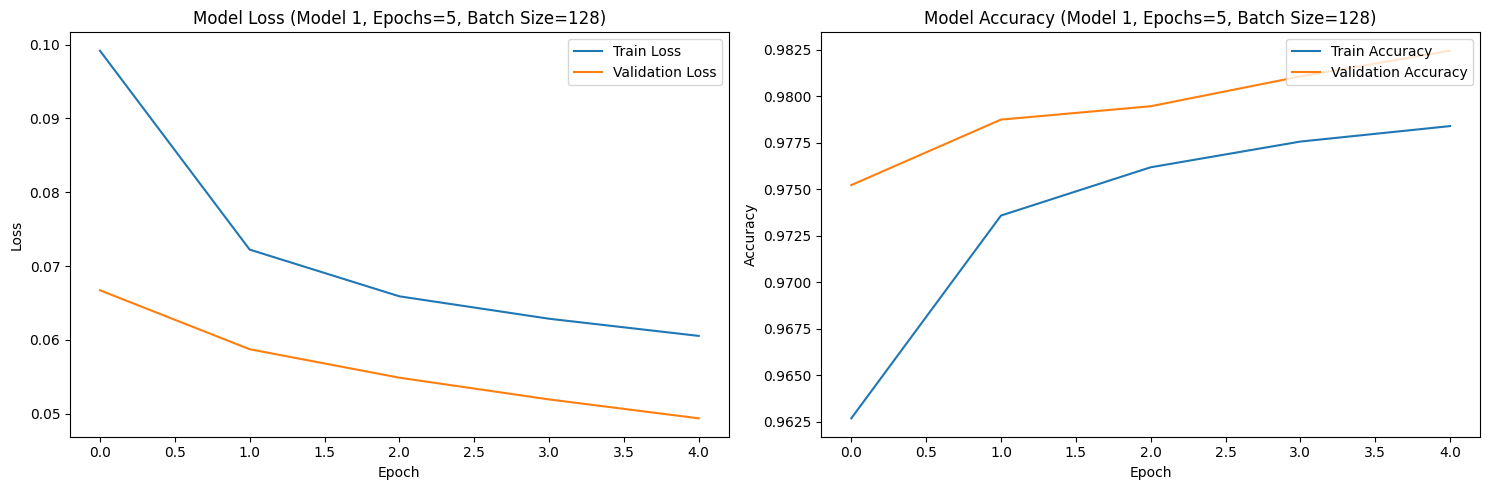

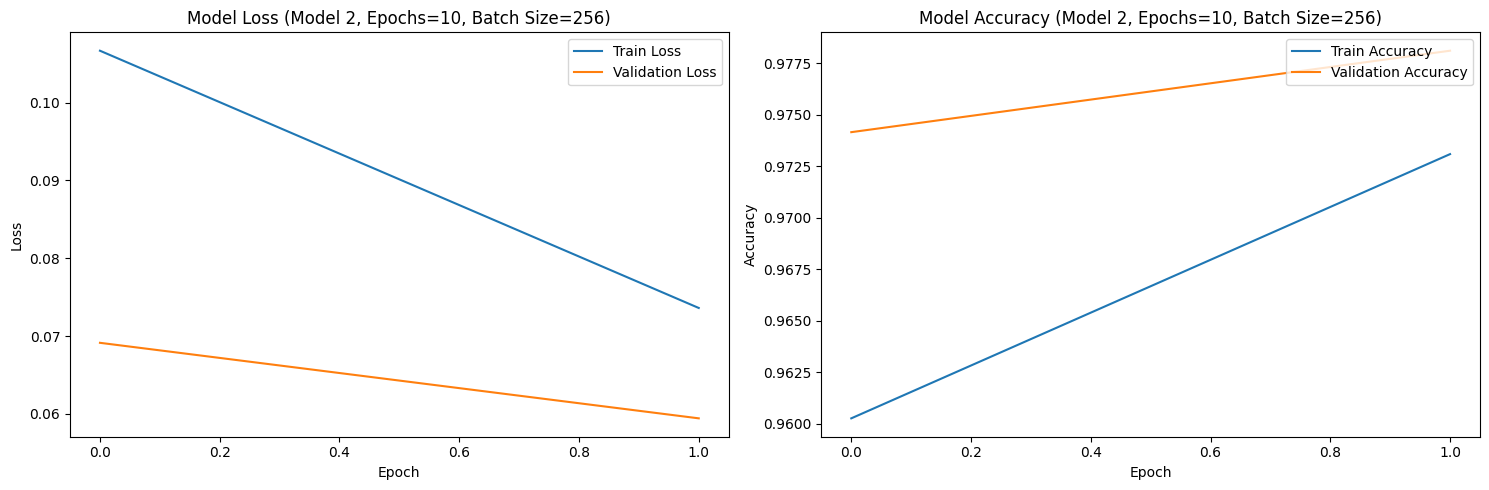

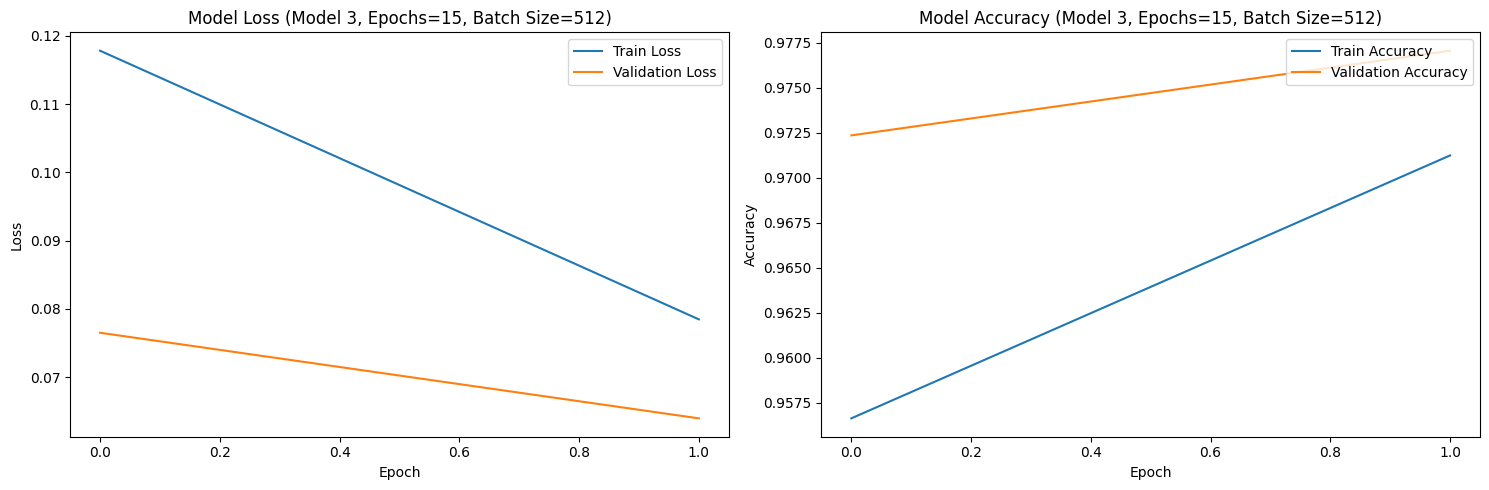

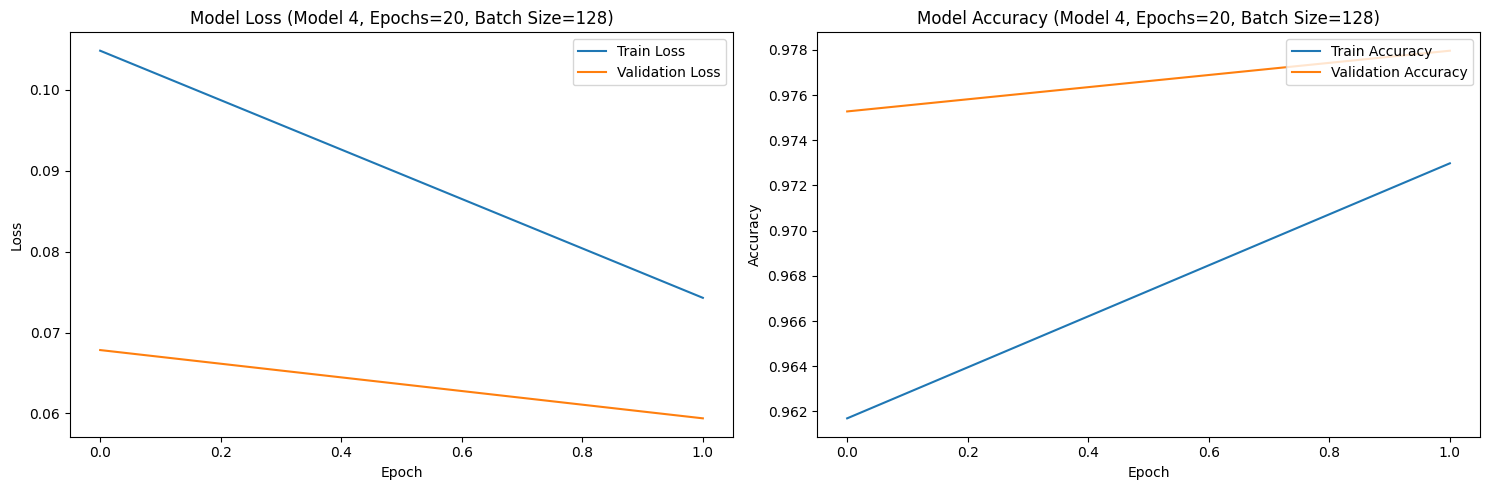

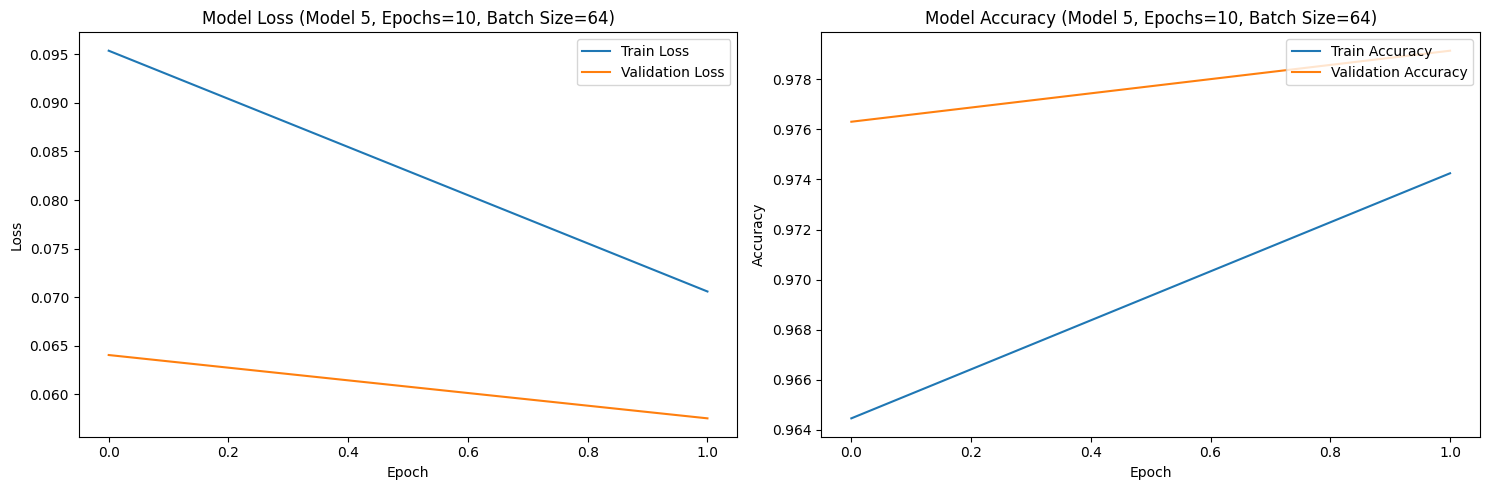

In [15]:
import matplotlib.pyplot as plt

# Function to plot training and validation results side by side
def plot_history(history, title_suffix=""):
    # Create subplots: 1 row, 2 columns
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Plot loss on the first subplot (left)
    axs[0].plot(history.history['loss'], label='Train Loss')
    axs[0].plot(history.history['val_loss'], label='Validation Loss')
    axs[0].set_title(f'Model Loss {title_suffix}')
    axs[0].set_ylabel('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(loc='upper right')

    # Plot accuracy on the second subplot (right)
    axs[1].plot(history.history['accuracy'], label='Train Accuracy')
    axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axs[1].set_title(f'Model Accuracy {title_suffix}')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(loc='upper right')

    # Display the plots
    plt.tight_layout()
    plt.show()

# Displaying results for all models
for i, history in enumerate(histories):
    plot_history(history, title_suffix=f'(Model {i+1}, Epochs={train_params[i][0]}, Batch Size={train_params[i][1]})')

## Performance

In [16]:
import pandas as pd

# Function to read the CSV logs and display them as a DataFrame
def read_and_display_csv_logs(epochs, batch_size):
    # Construct the file name based on the training parameters
    file_name = f'model_{epochs}epochs_{batch_size}batch_size_log.csv'
    
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_name)
    
    # Display the DataFrame with spacing
    print(f"Results for Model with {epochs} Epochs and Batch Size {batch_size}:")
    display(df)  # or use print(df) if not in a notebook environment
    print("\n" + "-"*50 + "\n")  # Add a separator line

# Call the function for each model
for (epochs, batch_size) in train_params:
    read_and_display_csv_logs(epochs, batch_size)

Results for Model with 5 Epochs and Batch Size 128:


,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.962679,0.099182,0.975227,0.066710
1,1,0.973589,0.072227,0.978752,0.058721
2,2,0.976187,0.065892,0.979471,0.054863
3,3,0.977570,0.062854,0.981075,0.051919
4,4,0.978403,0.060527,0.982459,0.049354



--------------------------------------------------

Results for Model with 10 Epochs and Batch Size 256:


,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.960269,0.106675,0.974155,0.069138
1,1,0.973091,0.073615,0.978108,0.059432



--------------------------------------------------

Results for Model with 15 Epochs and Batch Size 512:


,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.956633,0.117837,0.972358,0.076514
1,1,0.971244,0.078478,0.977063,0.063975



--------------------------------------------------

Results for Model with 20 Epochs and Batch Size 128:


,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.961693,0.104843,0.975277,0.067840
1,1,0.972981,0.074296,0.977965,0.059399



--------------------------------------------------

Results for Model with 10 Epochs and Batch Size 64:


,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.964457,0.095353,0.976308,0.064058
1,1,0.974249,0.070592,0.979145,0.057547



--------------------------------------------------



# TASK6: WRITE CODE TO SHOW ERRORS

In [17]:
import pandas as pd

# ฟังก์ชันสำหรับแสดงข้อผิดพลาด
def show_errors(x_test, y_test, y_pred, char_map, model_index):
    # แปลงผลลัพธ์ที่ทำนายและค่าจริงให้อยู่ใน DataFrame
    errors = pd.DataFrame({
        'word': [translate_features(x_test, i, char_map) for i in range(len(x_test))],
        'y_pred': y_pred.flatten(),
        'y_test': y_test.flatten()
    })

    # กรองเฉพาะแถวที่ทำนายผิดพลาด (ค่าจริงและค่าทำนายไม่ตรงกัน)
    errors = errors[errors['y_pred'] != errors['y_test']]

    # แสดงผลลัพธ์ 5 แถวแรกที่ทำนายผิดพลาดสำหรับโมเดลปัจจุบัน
    print(f"Errors for Model {model_index + 1}:")
    print(errors.head())

    # แสดงจำนวนแถวที่ทายผิดทั้งหมด
    total_errors = len(errors)
    total_predictions = len(y_test)
    print(f"Total errors for Model {model_index + 1}: {total_errors} out of {total_predictions} predictions")
    print("\n" + "-"*50 + "\n")

# ฟังก์ชันแปลง features ให้เป็น string
def translate_features(tfeature, index, char_map):
    # แปลงอักขระจาก features เป็นตัวอักษร
    feature = tfeature[index].reshape(21)
    word = ''.join([char_map[int(f)] for f in feature if int(f) in char_map])
    return word

# แสดงข้อผิดพลาดของทุกโมเดลในลิสต์
for i, model in enumerate(models):
    # ทำนายผลโดยใช้โมเดลที่ i
    y_pred_prob = model.predict(x_test_char)
    y_pred = (y_pred_prob >= 0.5).astype(int)

    # แสดงข้อผิดพลาดของโมเดลที่ i
    show_errors(x_test_char, y_test, y_pred, CHARS_MAP, i)

14896/14896 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step
Errors for Model 1:
    word  y_pred  y_test
165            1       0
228            1       0
315            1       0
594            1       0
754            1       0
Total errors for Model 1: 9505 out of 476647 predictions

--------------------------------------------------

14896/14896 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step
Errors for Model 2:
    word  y_pred  y_test
104            0       1
165            1       0
228            1       0
274            1       0
294            1       0
Total errors for Model 2: 12957 out of 476647 predictions

--------------------------------------------------

14896/14896 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step
Errors for Model 3:
    word  y_pred  y_test
104            0       1
165            1       0
228            1       0
294            1       0
315            1       0
Total errors for Model 3: 14169 out of 476647 predictions

--------------------------------------------------

14896/14896 ━━━━━━━━

# TASK7: QUESTIONS

#### Q 7.1) Does the dropout layer improve the model performance? Why?
**ตอบ**: Dropout layer เข้ามามีบทบาทในเรื่องของการช่วยลดปัญหา overfitting หรือก็คือโมเดลของเราเรียนรู้ได้ดีเกินไปในข้อมูลตัวอย่าง แต่กลับทำผลลัพธ์ได้ไม่ดีในข้อมูลทดสอบ โดย Dropout layer จะสุ่มปิดการทำงานของบาง neuron(node) เพื่อป้องกันไม่ให้โมเดลพึ่งมา neuron(node) ใด neuron(node) หนึ่งมากจนเกิดไปครับ  

#### Q 7.2) What is the suitable neural network layer (Eg. dense, LSTM, ..., etc) on the word-segmentation task? What is the reason behind it?
**ตอบ**: จากการทำงานข้อที่ 4 1D-CNN ให้ประสิทธิภาพที่ดีกว่า (ถ้าชุดข้อมูลฝึกดีพร้อมแบบงานนี้น่ะนะ) เมื่อเทียบกับการใช้ NN ธรรมดา ทั้งในด้านของ Accuracy, Time เลยคิดว่า 1D-CNN น่าจะเหมาะสมสำหรับการทำ word-segmentation ครับ
แต่หลังจากที่ไปลองอ่านเพิ่มเติมมาถ้าข้อความมีขนาดยาว ๆ 1D-CNN อาจจะไม่ใช่ตัวเลือกที่เหมาะสมที่สุด เพราะ เรามี LSTM ที่มีความสามารถในการจดจำรูปแบบหรือข้อความที่มีขนาดยาวได้ดีกว่า 1D-CNN ครับ

#### Q 7.3) Apart from hyperparameter tuning, neural network design, and architecture, what else can we do to improve the task accuracy? to create a better model?
**ตอบ**: โดยทั่วไป "การเพิ่มชุดข้อมูลฝึกฝน" มักเป็นสิ่งแรก ๆ ที่คนคิดถึงกันเวลา ML/DL ทำงานได้ไม่ดี เพราะมันช่วยแก้ปัญหาได้หลายด้านทั้ง ชุดข้อมูลมีขนาดเล็ก, ชุดข้อมูลไม่สมดุลกัน, ข้อมูลมีการกระจายตัวไม่ปกติ(มักเจอในงาน ML) เป็นต้น
นอกจากการเพิ่มชุดข้อมูลฝึกฝนแล้ว "การเตรียมข้อมูล" (Clean, Integration,Reduction, Transformation) ก็เป็นอีกสิ่งหนึ่งที่ช่วยให้โมเดลของเรามีประสิทธิภาพดีขึ้นได้ครับ